In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import os
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import random
from utils import caculate_metric
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"{'GPU' if device.type == 'cuda' else 'CPU'} Available")
# 固定随机种子等操作
seed_n = 911
print('seed is ' + str(seed_n))
g = torch.Generator()
g.manual_seed(seed_n)
random.seed(seed_n)
np.random.seed(seed_n)
torch.manual_seed(seed_n)
torch.cuda.manual_seed(seed_n)
torch.cuda.manual_seed_all(seed_n)

# 模型权重保存地址
model_save_path_list = r'/content'

GPU Available
seed is 911


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# 定义网络模型
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv1d(1024, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU()
        )
        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv1d(1280, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU()
        )
        self.cnn3 = torch.nn.Sequential(
            torch.nn.Conv1d(2560, 512, kernel_size=9, padding='same'),  # 减少输出通道数
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU()
        )

        # Attention
        self.attention = torch.nn.MultiheadAttention(
            embed_dim=1024,  # 减少 Attention 的特征维度
            num_heads=8,  # 减少注意力头数量
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = torch.nn.GRU(
            input_size=1024,  # Attention 输出维度减少
            hidden_size=128,  # 减少 GRU 的 hidden_size
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = torch.nn.LSTM(1024, 128, bidirectional=True, batch_first=True)  # 减少 hidden_size

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 16),  # 减少输出维度
        )

        # 分类层
        self.fc2 = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x1, x2, x3, labels=None):
        """
        inputs:
            - x1, x2, x3: 输入的三个特征
            - labels: 目标标签，通常用于计算损失函数
        """
        # CNN 分支
        x1 = x1.unsqueeze(1)  # (batch_size, 1, 1024)
        x2 = x2.unsqueeze(1)  # (batch_size, 1, 1280)
        x3 = x3.unsqueeze(1)  # (batch_size, 1, 2560)

        x1 = x1.permute(0, 2, 1)  # (batch_size, 1024, 1)
        x2 = x2.permute(0, 2, 1)  # (batch_size, 1280, 1)
        x3 = x3.permute(0, 2, 1)  # (batch_size, 2560, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)  # (batch_size, 1, 128)
        out2 = self.cnn2(x2).permute(0, 2, 1)  # (batch_size, 1, 128)
        out3 = self.cnn3(x3).permute(0, 2, 1)  # (batch_size, 1, 256)

        # 拼接三个 CNN 输出
        merged = torch.cat([out1, out2, out3], dim=-1)  # (batch_size, 1, 512)
        # merged = out2
        # Attention
        attn_out, _ = self.attention(merged, merged, merged)  # (batch_size, seq_len, 512)

        # BiGRU
        bigru_out, _ = self.bilstm(attn_out)  # 只传入 merged
        # (batch_size, seq_len, 128)

        # 全连接层
        mlp_out = self.fc1(bigru_out)  # (batch_size, seq_len, 8)
        out = self.fc2(mlp_out).squeeze(-1)  # (batch_size, seq_len)

        # 取最后一个时间步的输出作为最终分类结果
        final_out = out[:, -1]  # (batch_size)

        return final_out, out1, out2, out3, merged, attn_out, bigru_out, mlp_out


# 定义可视化函数（添加标准化）
def visualize_layer(features, labels, layer_name):
    """可视化指定层的t-SNE分布"""
    # 标准化特征
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # t-SNE降维
    tsne = TSNE(n_components=2, perplexity=30, random_state=911)
    embeddings = tsne.fit_transform(scaled_features)

    # 创建画布
    plt.figure(figsize=(8, 6))

    # 绘制正样本
    mask_pos = labels == 1
    plt.scatter(embeddings[mask_pos, 0], embeddings[mask_pos, 1],
                c='red', s=10, alpha=0.7, label='Positive')

    # 绘制负样本
    mask_neg = labels == 0
    plt.scatter(embeddings[mask_neg, 0], embeddings[mask_neg, 1],
                c='blue', s=10, alpha=0.7, label='Negative')

    # 添加图例和标题
    plt.legend()
    plt.title(f't-SNE Visualization - {layer_name} Layer')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()


# 1. 加载测试数据（三个独立的特征）
test_data_1 = torch.load(r'/content/drive/MyDrive/merged_test_ProtT5.pt').float()
test_data_2 = torch.load(r'/content/drive/MyDrive/merged_test_esm1b.pt').float()
test_data_3 = torch.load(r'/content/drive/MyDrive/merged_test_esm2_t36.pt').float()

# 2. 创建标签
test_labels = np.array([1] * 218 + [0] * 260)

# 可视化初始输入
layers = {
    "Input_1": test_data_1.cpu().numpy(),
    "Input_2": test_data_2.cpu().numpy(),
    "Input_3": test_data_3.cpu().numpy()
}

for layer_name, features in layers.items():
    visualize_layer(features, test_labels, layer_name)

# 3. 初始化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

# 加载预训练模型
pretrained_model_path = '/content/model_1.pt'  # 替换为你的预训练模型路径
try:
    model = torch.load(pretrained_model_path, map_location=device,weights_only=False)
    model.eval()
    print("成功加载预训练模型")
except FileNotFoundError:
    print(f"错误：未找到预训练模型文件 {pretrained_model_path}")
except Exception as e:
    print(f"错误：加载预训练模型时发生错误 {e}")

# 4. 获取各层输出
with torch.no_grad():
    # 前向传播获取各层输出
    outputs = model(
        test_data_1.to(device),
        test_data_2.to(device),
        test_data_3.to(device)
    )

    # 解包各层输出
    final_out, out1, out2, out3, merged, attn_out, bigru_out, mlp_out = outputs

# 5. 处理各层输出的维度（转换为二维特征）
layers = {
    "CNN1": out1.squeeze(1).cpu().numpy(),  # (batch_size, 256)
    "CNN2": out2.squeeze(1).cpu().numpy(),  # (batch_size, 256)
    "CNN3": out3.squeeze(1).cpu().numpy(),  # (batch_size, 512)
    "Merged": merged.squeeze(1).cpu().numpy(),  # (batch_size, 1024)
    "Attention": attn_out.squeeze(1).cpu().numpy(),  # (batch_size, 1024)
    "BiGRU": bigru_out.squeeze(1).cpu().numpy(),  # (batch_size, 256)
    "MLP": mlp_out.squeeze(1).cpu().numpy(),  # (batch_size, 16)
}

# 6. 生成各层的可视化
for layer_name, features in layers.items():
    visualize_layer(features, test_labels, layer_name)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/merged_test_ProtT5.pt'

# 新段落

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


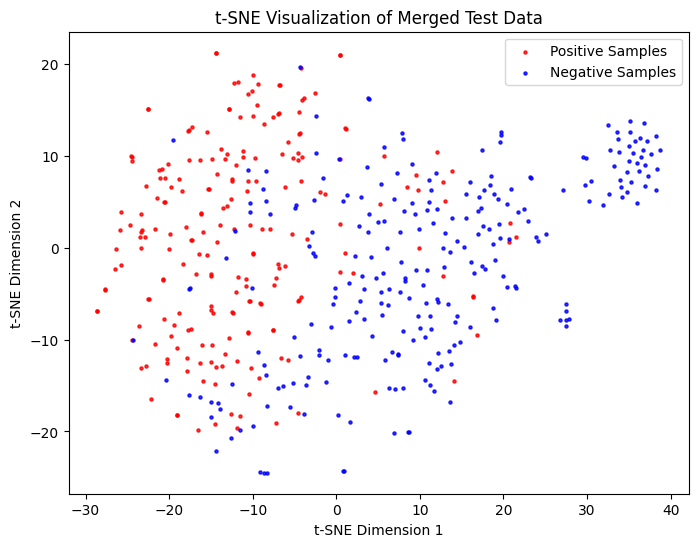

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1. 加载数据
test_data_1 = torch.load(r'/content/drive/MyDrive/merged_test_ProtT5.pt')
test_data_2 = torch.load(r'/content/drive/MyDrive/merged_test_esm1b.pt')
test_data_3 = torch.load(r'/content/drive/MyDrive/merged_test_esm2_t36.pt')

# 2. 合并特征数据（假设数据形状为 [样本数, 特征维度]）
test_data = torch.cat([test_data_1, test_data_2, test_data_3], dim=1)  # 沿特征维度拼接
test_data = test_data.cpu().detach().numpy()  # 将 PyTorch 张量转换为 NumPy 数组

# 3. 加载标签
test_labels_list = [1] * 218 + [0] * 260
test_labels = torch.tensor(test_labels_list, dtype=torch.float32).numpy()

# 4. 使用 t-SNE 进行降维
tsne = TSNE(n_components=2,  # 降维到 2 维
            perplexity=30,   # 困惑度（通常介于 5 到 50 之间）
            random_state=911)  # 随机种子，确保结果可复现
X_tsne = tsne.fit_transform(test_data)  # 降维后的数据

# 5. 可视化 t-SNE 结果
plt.figure(figsize=(8, 6))
# 分别绘制正样本和负样本
positive_indices = test_labels == 1
negative_indices = test_labels == 0
positive_scatter = plt.scatter(X_tsne[positive_indices, 0], X_tsne[positive_indices, 1], c='red', s=5, alpha=0.8, label='Positive Samples')
negative_scatter = plt.scatter(X_tsne[negative_indices, 0], X_tsne[negative_indices, 1], c='blue', s=5, alpha=0.8, label='Negative Samples')

# 添加图例
plt.legend()
plt.title('t-SNE Visualization of Merged Test Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
import numpy as np
import os


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1024, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1280, 256, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(2560, 512, kernel_size=9, padding='same'),  # 减少输出通道数
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        # Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=1024,
            num_heads=8,
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = nn.GRU(
            input_size=1024,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = nn.LSTM(1024, 128, bidirectional=True, batch_first=True)

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 16),
        )

        # 分类层
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels=None):
        """
        inputs:
            - x: 输入的特征
            - labels: 目标标签，通常用于计算损失函数
        """
        # CNN 分支
        x1 = x[:, :1024].unsqueeze(1)  # (batch_size, 1, 1024)
        x2 = x[:, 1024:1024 + 1280].unsqueeze(1)  # (batch_size, 1, 1280)
        x3 = x[:, 1024 + 1280:].unsqueeze(1)  # (batch_size, 1, 2560)

        x1 = x1.permute(0, 2, 1)    # (batch_size, 1024, 1)
        x2 = x2.permute(0, 2, 1)    # (batch_size, 1280, 1)
        x3 = x3.permute(0, 2, 1)    # (batch_size, 2560, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)   # (batch_size, 1, 128)
        out2 = self.cnn2(x2).permute(0, 2, 1)   # (batch_size, 1, 128)
        out3 = self.cnn3(x3).permute(0, 2, 1)   # (batch_size, 1, 256)

        # 拼接三个 CNN 输出
        merged = torch.cat([out1, out2, out3], dim=-1)  # (batch_size, 1, 512)

        # Attention
        attn_out, _ = self.attention(merged, merged, merged)  # (batch_size, seq_len, 512)

        # BiGRU
        bigru_out, _ = self.bigru(attn_out)

        # 全连接层
        mlp_out = self.fc1(bigru_out)  # (batch_size, seq_len, 8)
        out = self.fc2(mlp_out).squeeze(-1)  # (batch_size, seq_len)

        # 取最后一个时间步的输出作为最终分类结果
        final_out = out[:, -1]  # (batch_size)

        return final_out


def calculate_metric(all_predictions, all_labels, all_outputs):
    # 这里需要你自己实现指标计算逻辑，以下是简单示例，你需要根据实际情况修改
    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, matthews_corrcoef
    acc = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    auroc = roc_auc_score(all_labels, all_outputs)
    mcc = matthews_corrcoef(all_labels, all_predictions)
    specificity = recall_score(all_labels, all_predictions, pos_label=0)
    return (acc, precision, recall, specificity, f1, auroc, mcc), None, None


def cv(train_data_1, train_data_2, train_data_3, train_label, batch_size, lr, epochs, num_kfold=10, p=0.5):
    x = torch.cat([train_data_1, train_data_2, train_data_3], dim=1)
    y = train_label

    model_list = []  # 存储每一折的模型
    accuracy_sum, recall_sum, spe_sum, precision_sum, auroc_sum, f1_sum, mcc_sum = [], [], [], [], [], [], []

    k_num = num_kfold  # k 折
    k = 0
    skf = KFold(n_splits=k_num, shuffle=True, random_state=911)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_save_dir = "./saved_models"
    os.makedirs(model_save_dir, exist_ok=True)

    for train_index, valid_index in skf.split(x):
        k += 1
        # 划分训练集和验证集
        x_train = x[train_index]
        x_valid = x[valid_index]

        y_train = y[train_index]
        y_valid = y[valid_index]

        # 该折训练集的样本分布
        num_positive = np.sum(y_train.cpu().detach().numpy())
        num_negative = len(y_train) - num_positive
        print('正样本：%d个, 负样本：%d个, 正/负: %.2f' % (num_positive, num_negative, num_positive / num_negative))

        criterion = nn.BCELoss()
        print(f'使用 BCE')

        model = Net()  # 使用自定义模型
        model.to(device)
        optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=0.0, betas=(0.9, 0.999))

        # 创建训练集 dataloader
        train_dataset = TensorDataset(x_train, y_train)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

        # 创建验证集 dataloader
        val_dataset = TensorDataset(x_valid, y_valid)
        val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

        best_mcc = 0.0
        best_auroc = 0.0
        best_epoch = 0
        best_metrics = {}
        best_model_state = None
        print('------------CV:%d-----------' % k)

        for epoch in range(epochs):
            model.train()
            train_loss_sum = 0.0
            val_loss_sum = 0.0
            for inputs, labels in train_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                train_loss_sum += loss.item()
                loss.backward()
                optimizer.step()

            model.eval()
            all_outputs, all_labels, all_predictions = [], [], []
            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    all_outputs.extend(outputs.tolist())
                    all_labels.extend(labels.tolist())
                    all_predictions.extend((outputs.data > p).int().tolist())

            metrics, _, _ = calculate_metric(all_predictions, all_labels, all_outputs)
            acc_value, pre_value, recall_value, spe_value, f1_value, auroc_value, mcc_value = metrics
            print(f"Epoch {epoch + 1}: Acc: {acc_value:.4f}, Recall: {recall_value:.4f}, SP: {spe_value:.4f}, Pre: {pre_value:.4f}, Auroc: {auroc_value:.4f}, F1: {f1_value:.4f}, MCC: {mcc_value:.4f}")

            if mcc_value > best_mcc or (mcc_value == best_mcc and auroc_value > best_auroc):
                best_epoch = epoch + 1
                best_mcc = mcc_value
                best_auroc = auroc_value
                save_path = os.path.join(model_save_dir, f'model_{k}.pt')
                torch.save(model, save_path)
                best_metrics = {
                    'acc': acc_value,
                    'recall': recall_value,
                    'specificity': spe_value,
                    'precision': pre_value,
                    'auroc': auroc_value,
                    'f1': f1_value,
                    'mcc': mcc_value
                }

        print(f"Best Epoch {best_epoch} Acc: {best_metrics['acc']:.4f}, Recall: {best_metrics['recall']:.4f}, SP: {best_metrics['specificity']:.4f}, Pre: {best_metrics['precision']:.4f}, Auroc: {best_metrics['auroc']:.4f}, F1: {best_metrics['f1']:.4f}, MCC: {best_metrics['mcc']:.4f}, Saved model for CV fold {k}")
        accuracy_sum.append(best_metrics['acc'])
        recall_sum.append(best_metrics['recall'])
        spe_sum.append(best_metrics['specificity'])
        precision_sum.append(best_metrics['precision'])
        auroc_sum.append(best_metrics['auroc'])
        f1_sum.append(best_metrics['f1'])
        mcc_sum.append(best_metrics['mcc'])

    print('done!')
    return accuracy_sum, recall_sum, spe_sum, precision_sum, auroc_sum, f1_sum, mcc_sum

In [ ]:
# 训练集输入特征
train_data_1 = torch.load(r'/content/drive/MyDrive/merged_train_ProtT5.pt', weights_only=True)  # (batch_size, 2560)
train_data_2 = torch.load(r'/content/drive/MyDrive/merged_train_esm1b.pt', weights_only=True)  # (batch_size, 1280)
train_data_3 = torch.load(r'/content/drive/MyDrive/merged_train_esm2_t36.pt', weights_only=True)  # (batch_size, 1024)

# 标签
train_labels_list = [1] * 1004 + [0] * 1059  # 正负样本标签
train_label = torch.tensor(train_labels_list, dtype=torch.float)

from sklearn.utils import shuffle

# 将数据转为 numpy 进行同步打乱
train_data_1_np = train_data_1.cpu().numpy()
train_data_2_np = train_data_2.cpu().numpy()
train_data_3_np = train_data_3.cpu().numpy()
train_label_np = train_label.cpu().numpy()

# ✅ 同步打乱
train_data_1_np, train_data_2_np, train_data_3_np, train_label_np = shuffle(
    train_data_1_np, train_data_2_np, train_data_3_np, train_label_np, random_state=911
)

# 转回 tensor
train_data_1 = torch.from_numpy(train_data_1_np)
train_data_2 = torch.from_numpy(train_data_2_np)
train_data_3 = torch.from_numpy(train_data_3_np)
train_label = torch.from_numpy(train_label_np)

# 训练参数
p_value = 0.5  # 阈值
k_value = 10   # k 折
print('阈值为%.1f' % p_value)

# ✅ 调整 cv 调用
acc, recall, spe, pre, auroc, f1, mcc = cv(
    train_data_1=train_data_1,
    train_data_2=train_data_2,
    train_data_3=train_data_3,
    train_label=train_label,
    batch_size=128,
    lr=0.00003,
    epochs=30,
    num_kfold=k_value,
    p=p_value
)

阈值为0.5
正样本：914个, 负样本：942个, 正/负: 0.97
使用 BCE
------------CV:1-----------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Acc: 0.5652, Recall: 0.0000, SP: 1.0000, Pre: 0.0000, Auroc: 0.9149, F1: 0.0000, MCC: 0.0000
Epoch 2: Acc: 0.5894, Recall: 0.0556, SP: 1.0000, Pre: 1.0000, Auroc: 0.9303, F1: 0.1053, MCC: 0.1794
Epoch 3: Acc: 0.8647, Recall: 0.8222, SP: 0.8974, Pre: 0.8605, Auroc: 0.9458, F1: 0.8409, MCC: 0.7239
Epoch 4: Acc: 0.8889, Recall: 0.8778, SP: 0.8974, Pre: 0.8681, Auroc: 0.9593, F1: 0.8729, MCC: 0.7743
Epoch 5: Acc: 0.9034, Recall: 0.9333, SP: 0.8803, Pre: 0.8571, Auroc: 0.9715, F1: 0.8936, MCC: 0.8079
Epoch 6: Acc: 0.9130, Recall: 0.9667, SP: 0.8718, Pre: 0.8529, Auroc: 0.9752, F1: 0.9062, MCC: 0.8314
Epoch 7: Acc: 0.8986, Recall: 0.9556, SP: 0.8547, Pre: 0.8350, Auroc: 0.9802, F1: 0.8912, MCC: 0.8033
Epoch 8: Acc: 0.9179, Recall: 0.8889, SP: 0.9402, Pre: 0.9195, Auroc: 0.9796, F1: 0.9040, MCC: 0.8326
Epoch 9: Acc: 0.8792, Recall: 0.9778, SP: 0.8034, Pre: 0.7928, Auroc: 0.9804, F1: 0.8756, MCC: 0.7766
Epoch 10: Acc: 0.9082, Recall: 0.9667, SP: 0.8632, Pre: 0.8447, Auroc: 0.9802, F1:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Acc: 0.4879, Recall: 0.0000, SP: 1.0000, Pre: 0.0000, Auroc: 0.9385, F1: 0.0000, MCC: 0.0000
Epoch 2: Acc: 0.7440, Recall: 0.5000, SP: 1.0000, Pre: 1.0000, Auroc: 0.9497, F1: 0.6667, MCC: 0.5726
Epoch 3: Acc: 0.8841, Recall: 0.8491, SP: 0.9208, Pre: 0.9184, Auroc: 0.9549, F1: 0.8824, MCC: 0.7707
Epoch 4: Acc: 0.8986, Recall: 0.9057, SP: 0.8911, Pre: 0.8972, Auroc: 0.9623, F1: 0.9014, MCC: 0.7970
Epoch 5: Acc: 0.9179, Recall: 0.9151, SP: 0.9208, Pre: 0.9238, Auroc: 0.9662, F1: 0.9194, MCC: 0.8357
Epoch 6: Acc: 0.8986, Recall: 0.9340, SP: 0.8614, Pre: 0.8761, Auroc: 0.9695, F1: 0.9041, MCC: 0.7985
Epoch 7: Acc: 0.9179, Recall: 0.9151, SP: 0.9208, Pre: 0.9238, Auroc: 0.9674, F1: 0.9194, MCC: 0.8357
Epoch 8: Acc: 0.9179, Recall: 0.9434, SP: 0.8911, Pre: 0.9009, Auroc: 0.9670, F1: 0.9217, MCC: 0.8364
Epoch 9: Acc: 0.9130, Recall: 0.9340, SP: 0.8911, Pre: 0.9000, Auroc: 0.9661, F1: 0.9167, MCC: 0.8264
Epoch 10: Acc: 0.9130, Recall: 0.9245, SP: 0.9010, Pre: 0.9074, Auroc: 0.9670, F1:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Acc: 0.4563, Recall: 0.0000, SP: 1.0000, Pre: 0.0000, Auroc: 0.8978, F1: 0.0000, MCC: 0.0000
Epoch 2: Acc: 0.4660, Recall: 0.0179, SP: 1.0000, Pre: 1.0000, Auroc: 0.9120, F1: 0.0351, MCC: 0.0907
Epoch 3: Acc: 0.8204, Recall: 0.7143, SP: 0.9468, Pre: 0.9412, Auroc: 0.9298, F1: 0.8122, MCC: 0.6689
Epoch 4: Acc: 0.8641, Recall: 0.8661, SP: 0.8617, Pre: 0.8818, Auroc: 0.9370, F1: 0.8739, MCC: 0.7267
Epoch 5: Acc: 0.8738, Recall: 0.8839, SP: 0.8617, Pre: 0.8839, Auroc: 0.9461, F1: 0.8839, MCC: 0.7456
Epoch 6: Acc: 0.8883, Recall: 0.9286, SP: 0.8404, Pre: 0.8739, Auroc: 0.9568, F1: 0.9004, MCC: 0.7755
Epoch 7: Acc: 0.9029, Recall: 0.9107, SP: 0.8936, Pre: 0.9107, Auroc: 0.9581, F1: 0.9107, MCC: 0.8043
Epoch 8: Acc: 0.8981, Recall: 0.9286, SP: 0.8617, Pre: 0.8889, Auroc: 0.9639, F1: 0.9083, MCC: 0.7946
Epoch 9: Acc: 0.8932, Recall: 0.8661, SP: 0.9255, Pre: 0.9327, Auroc: 0.9557, F1: 0.8981, MCC: 0.7886
Epoch 10: Acc: 0.8835, Recall: 0.8571, SP: 0.9149, Pre: 0.9231, Auroc: 0.9598, F1:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Acc: 0.5243, Recall: 0.0000, SP: 1.0000, Pre: 0.0000, Auroc: 0.9432, F1: 0.0000, MCC: 0.0000
Epoch 2: Acc: 0.6796, Recall: 0.3367, SP: 0.9907, Pre: 0.9706, Auroc: 0.9537, F1: 0.5000, MCC: 0.4406
Epoch 3: Acc: 0.8689, Recall: 0.8163, SP: 0.9167, Pre: 0.8989, Auroc: 0.9602, F1: 0.8556, MCC: 0.7390
Epoch 4: Acc: 0.9029, Recall: 0.9286, SP: 0.8796, Pre: 0.8750, Auroc: 0.9664, F1: 0.9010, MCC: 0.8073
Epoch 5: Acc: 0.9078, Recall: 0.9286, SP: 0.8889, Pre: 0.8835, Auroc: 0.9712, F1: 0.9055, MCC: 0.8165
Epoch 6: Acc: 0.9223, Recall: 0.9694, SP: 0.8796, Pre: 0.8796, Auroc: 0.9746, F1: 0.9223, MCC: 0.8490
Epoch 7: Acc: 0.9417, Recall: 0.9694, SP: 0.9167, Pre: 0.9135, Auroc: 0.9766, F1: 0.9406, MCC: 0.8851
Epoch 8: Acc: 0.9417, Recall: 0.9592, SP: 0.9259, Pre: 0.9216, Auroc: 0.9749, F1: 0.9400, MCC: 0.8841
Epoch 9: Acc: 0.9126, Recall: 0.9592, SP: 0.8704, Pre: 0.8704, Auroc: 0.9771, F1: 0.9126, MCC: 0.8296
Epoch 10: Acc: 0.9272, Recall: 0.9286, SP: 0.9259, Pre: 0.9192, Auroc: 0.9787, F1:

In [ ]:
# 打印每折的指标和平均值
for fold_idx, Accuracy, Recall, Spe, Precision, Auroc, F1, MCC in zip(range(1, k_value+1), acc, recall, spe, pre, auroc, f1, mcc):
    print(f"Fold {fold_idx} - Accuracy: {Accuracy:.4f}, Recall: {Recall:.4f}, Sp: {Spe:.4f}, Precision: {Precision:.4f}, Auroc: {Auroc:.4f}, F1 Score: {F1:.4f}, MCC: {MCC:.4f}")
print('**********************************************')
print(f"Mean Accuracy: {np.mean(acc):.4f}±{np.std(acc):.4f}")
print(f"Mean Recall: {np.mean(recall):.4f}±{np.std(recall):.4f}")
print(f"Mean Sp: {np.mean(spe):.4f}±{np.std(spe):.4f}")
print(f"Mean Precision: {np.mean(pre):.4f}±{np.std(pre):.4f}")
print(f"Mean Auroc: {np.mean(auroc):.4f}±{np.std(auroc):.4f}")
print(f"Mean F1 Score: {np.mean(f1):.4f}±{np.std(f1):.4f}")
print(f"Mean MCC: {np.mean(mcc):.4f}±{np.std(mcc):.4f}")

Fold 1 - Accuracy: 0.9420, Recall: 0.9444, Sp: 0.9402, Precision: 0.9239, Auroc: 0.9757, F1 Score: 0.9341, MCC: 0.8825
Fold 2 - Accuracy: 0.9179, Recall: 0.9340, Sp: 0.9010, Precision: 0.9083, Auroc: 0.9652, F1 Score: 0.9209, MCC: 0.8359
Fold 3 - Accuracy: 0.8937, Recall: 0.9300, Sp: 0.8598, Precision: 0.8611, Auroc: 0.9507, F1 Score: 0.8942, MCC: 0.7901
Fold 4 - Accuracy: 0.9223, Recall: 0.9196, Sp: 0.9255, Precision: 0.9364, Auroc: 0.9625, F1 Score: 0.9279, MCC: 0.8439
Fold 5 - Accuracy: 0.9466, Recall: 0.9348, Sp: 0.9561, Precision: 0.9451, Auroc: 0.9747, F1 Score: 0.9399, MCC: 0.8919
Fold 6 - Accuracy: 0.9175, Recall: 0.9145, Sp: 0.9213, Precision: 0.9386, Auroc: 0.9677, F1 Score: 0.9264, MCC: 0.8329
Fold 7 - Accuracy: 0.9369, Recall: 0.9592, Sp: 0.9167, Precision: 0.9126, Auroc: 0.9757, F1 Score: 0.9353, MCC: 0.8748
Fold 8 - Accuracy: 0.9223, Recall: 0.9293, Sp: 0.9159, Precision: 0.9109, Auroc: 0.9720, F1 Score: 0.9200, MCC: 0.8447
Fold 9 - Accuracy: 0.8835, Recall: 0.8222, Sp: 0

In [ ]:
import torch
import os
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

p_value = 0.5

def test(test_data_1, test_data_2, test_data_3, test_label, batch_size, model, p):
    X1, X2, X3, y = test_data_1, test_data_2, test_data_3, test_label

    test_dataset = TensorDataset(X1, X2, X3, y)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    all_labels = []
    all_outputs = []
    all_predictions = []

    model.to(device)
    model.eval()

    with torch.no_grad():
        for inputs1, inputs2, inputs3, labels in test_dataloader:
            inputs1, inputs2, inputs3, labels = inputs1.to(device), inputs2.to(device), inputs3.to(device), labels.to(device)
            outputs= model(inputs1, inputs2, inputs3)
            all_outputs.extend(outputs.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
            all_predictions.extend((outputs > p).int().cpu().tolist())

    # 这里假设 caculate_metric 函数已经定义
    metrics, _, _ = caculate_metric(all_predictions, all_labels, all_outputs)
    acc_value, pre_value, recall_value, spe_value, f1_value, auroc_value, mcc_value = metrics

    return acc_value, recall_value, spe_value, pre_value, auroc_value, f1_value, mcc_value

# 统计各项指标
acc_list, recall_list, spe_list, pre_list, auroc_list, f1_list, mcc_list = [], [], [], [], [], [], []

# ✅ 测试集
test_data_1 = torch.load(r'/content/drive/MyDrive/merged_test_ProtT5.pt')
test_data_2 = torch.load(r'/content/drive/MyDrive/merged_test_esm1b.pt')
test_data_3 = torch.load(r'/content/drive/MyDrive/merged_test_esm2_t36.pt')

test_labels_list = [1] * 218  + [0] * 260
test_label = torch.tensor(test_labels_list, dtype=torch.float32)

# 假设 k_value 已经定义
k_value = 10  # 示例值，根据实际情况修改
# 假设 model_save_path_list 已经定义
model_save_path_list = '.'  # 示例值，根据实际情况修改

# ✅ k 折模型评估
for i in range(1, k_value + 1):
    model_path = os.path.join(model_save_path_list, f'model_{i}.pt')
    model = Net()
    # 将 weights_only 设置为 False
    model = torch.load(model_path, map_location=device, weights_only=False)
    model.to(device)

    acc, recall, spe, pre, auroc, f1, mcc = test(
        test_data_1=test_data_1,
        test_data_2=test_data_2,
        test_data_3=test_data_3,
        test_label=test_label,
        batch_size=64,
        model=model,
        p=p_value
    )

    acc_list.append(acc)
    recall_list.append(recall)
    spe_list.append(spe)
    pre_list.append(pre)
    auroc_list.append(auroc)
    f1_list.append(f1)
    mcc_list.append(mcc)

    print(f"Model {i} - Acc: {acc:.4f}, Recall: {recall:.4f}, Spe: {spe:.4f}, Pre: {pre:.4f}, "
          f"Auroc: {auroc:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}")

# ✅ 平均值和标准差
print('**********************************************')
print(f"Acc: {np.mean(acc_list):.4f} ± {np.std(acc_list):.4f}")
print(f"Recall: {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
print(f"Spe: {np.mean(spe_list):.4f} ± {np.std(spe_list):.4f}")
print(f"Pre: {np.mean(pre_list):.4f} ± {np.std(pre_list):.4f}")
print(f"Auroc: {np.mean(auroc_list):.4f} ± {np.std(auroc_list):.4f}")
print(f"F1: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
print(f"MCC: {np.mean(mcc_list):.4f} ± {np.std(mcc_list):.4f}")

FileNotFoundError: [Errno 2] No such file or directory: './model_1.pt'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import graphviz

In [ ]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import shap
from functools import partial
from sklearn.model_selection import KFold

# 设置SHAP结果保存路径
shap_results_path = "./shap_analysis"
os.makedirs(shap_results_path, exist_ok=True)

# 在模型定义后添加以下方法（用于SHAP兼容）
class Net(nn.Module):
    # ...（保持原有模型结构）...

    def shap_forward(self, x1, x2, x3):
        """专用SHAP前向方法（移除不必要的输出）"""
        with torch.no_grad():
            # 保持原有特征处理流程
            x1 = x1.unsqueeze(1).permute(0, 2, 1)
            x2 = x2.unsqueeze(1).permute(0, 2, 1)
            x3 = x3.unsqueeze(1).permute(0, 2, 1)

            out1 = self.cnn1(x1).permute(0, 2, 1)
            out2 = self.cnn2(x2).permute(0, 2, 1)
            out3 = self.cnn3(x3).permute(0, 2, 1)

            merged = torch.cat([out1, out2, out3], dim=-1)
            attn_out, _ = self.attention(merged, merged, merged)
            bigru_out, _ = self.bigru(attn_out)
            mlp_out = self.fc1(bigru_out)
            final_out = self.fc2(mlp_out).squeeze(-1)

            return final_out

def prepare_shap_data(test_data_1, test_data_2, test_data_3):
    """准备SHAP输入数据"""
    # 转换为numpy数组并合并特征
    X = [
        test_data_1.cpu().numpy(),
        test_data_2.cpu().numpy(),
        test_data_3.cpu().numpy()
    ]
    return X

def analyze_shap(model, X, labels, fold_number):
    """生成SHAP分析报告"""
    # 使用前200个样本进行解释
    sample_idx = np.random.choice(X[0].shape[0], 200, replace=False)

    # 创建SHAP解释器（使用GPU模型）
    explainer = shap.DeepExplainer(
        partial(model.shap_forward, device=device),  # 使用专用方法
        torch.tensor(X[0][sample_idx], dtype=torch.float32, device=device),
        verbose=0
    )

    # 计算SHAP值
    shap_values = explainer.shap_values(
        torch.tensor(X[0][sample_idx], dtype=torch.float32, device=device)
    )
    shap_values = shap_values.cpu().numpy()

    # 转换标签为整数
    y = labels.cpu().numpy().astype(int)[sample_idx]

    # 生成全局解释图
    plt.figure(figsize=(18, 10))
    shap.summary_plot(shap_values, X[0][sample_idx],
                     plot_type="bar", show=False,
                     feature_names=["ProtT5", "ESM1B", "ESM2T36"])
    plt.savefig(os.path.join(shap_results_path,
                            f"global_shap_{fold_number}.png"))
    plt.close()

    # 生成交互式样本解释
    plt.figure(figsize=(12, 8))
    shap.initjs()
    shap.force_plot(
        explainer.expected_value,
        shap_values[0,:],
        X[0][0,:],
        feature_names=["ProtT5", "ESM1B", "ESM2T36"]
    )
    plt.savefig(os.path.join(shap_results_path,
                            f"sample_shap_{fold_number}_0.png"))
    plt.close()

# 在K折评估循环中集成SHAP分析
kfold = KFold(n_splits=k_value, shuffle=True, random_state=seed_n)
indices = kfold.split(test_data_1.shape[478])

for fold, (train_idx, val_idx) in enumerate(kfold.split(test_data_1.shape[478])):
    # 数据划分（示例，需根据实际情况调整）
    X_train = torch.stack([
        test_data_1[train_idx],
        test_data_2[train_idx],
        test_data_3[train_idx]
    ], dim=1)
    y_train = torch.tensor(test_labels_list[train_idx], dtype=torch.float32)

    X_val = torch.stack([
        test_data_1[val_idx],
        test_data_2[val_idx],
        test_data_3[val_idx]
    ], dim=1)
    y_val = torch.tensor(test_labels_list[val_idx], dtype=torch.float32)

    # 训练模型（您的现有训练代码）
    # model = Net()
    # optimizer = optim.Adam(model.parameters())
    # # ...训练过程...

    # SHAP分析（在验证集上进行）
    if fold == 0:  # 仅在第一个折叠生成详细分析
        X_shap = prepare_shap_data(
            test_data_1[test_idx],
            test_data_2[test_idx],
            test_data_3[test_idx]
        )
        analyze_shap(model, X_shap, y_val, fold+1)

    # 模型评估（您的现有测试代码）
    acc, recall, spe, pre, auroc, f1, mcc = test(
        test_data_1=test_data_1[test_idx],
        test_data_2=test_data_2[test_idx],
        test_data_3=test_data_3[test_idx],
        test_label=y_val,
        batch_size=64,
        model=model,
        p=p_value
    )

    # 保存结果
    acc_list.append(acc)
    # ...其他指标...

    print(f"Fold {fold+1} - Accuracy: {acc:.4f}")

# 生成汇总分析（所有折叠）
if len(acc_list) > 0:
    # 全局特征重要性聚合
    all_shap_values = []
    for fold in range(k_value):
        # 加载模型并计算SHAP值（示例）
        model = Net()
        model.load_state_dict(torch.load(f"models/model_{fold+1}.pt"))
        model.to(device)

        X_shap = prepare_shap_data(
            test_data_1,
            test_data_2,
            test_data_3
        )[:200]
        explainer = shap.DeepExplainer(
            partial(model.shap_forward, device=device),
            torch.tensor(X_shap[0], dtype=torch.float32, device=device)
        )
        shap_values = explainer.shap_values(
            torch.tensor(X_shap[0], dtype=torch.float32, device=device)
        )
        all_shap_values.append(shap_values.cpu().numpy())

    # 汇总分析
    combined_shap = np.vstack(all_shap_values)
    plt.figure(figsize=(18, 10))
    shap.summary_plot(combined_shap, X_shap[0],
                     plot_type="bar", show=False,
                     feature_names=["ProtT5", "ESM1B", "ESM2T36"])
    plt.savefig(os.path.join(shap_results_path, "combined_global_shap.png"))
    plt.close()

IndexError: tuple index out of range

In [ ]:
model = Net()

# 创建一个 Graphviz 的 Digraph 对象
dot = graphviz.Digraph(comment='Neural Network Architecture')

# 添加输入节点
dot.node('input_x1', 'ProtT5')
dot.node('input_x2', 'ESM-1b')
dot.node('input_x3', 'ESM-2')

# 添加 CNN1 分支的节点和边
dot.node('conv1', 'CNN(1024, 256, 9)')
dot.node('bn1', 'Batch Normalization')
dot.node('relu1', 'ReLU')
dot.edges([('input_x1', 'conv1'), ('conv1', 'bn1'), ('bn1','relu1')])

# 添加 CNN2 分支的节点和边
dot.node('conv2', 'CNN(1280, 256, 9)')
dot.node('bn2', 'Batch Normalization')
dot.node('relu2', 'ReLU')
dot.edges([('input_x2', 'conv2'), ('conv2', 'bn2'), ('bn2','relu2')])

# 添加 CNN3 分支的节点和边
dot.node('conv3', 'CNN(2560, 512, 9)')
dot.node('bn3', 'Batch Normalization')
dot.node('relu3', 'ReLU')
dot.edges([('input_x3', 'conv3'), ('conv3', 'bn3'), ('bn3','relu3')])

# 添加 Attention 层的节点和边
dot.node('attention', 'MultiheadAttention(512, 8)')
dot.edges([('relu1', 'attention'), ('relu2', 'attention'), ('relu3', 'attention')])

# 添加 BiGRU 层的节点和边
dot.node('bigru', 'BiGRU(512, 128)')
dot.edge('attention', 'bigru')

# 添加全连接层和分类层的节点和边
dot.node('fc1', 'MLP (256, 16, 1)')
#dot.node('fc2', 'FC2 (ReLU, Linear(16, 1), Sigmoid())')
dot.edge('bigru', 'fc1')
#dot.edge('fc1', 'fc2')

# 添加输出节点
dot.node('output', 'Output (1)')
dot.edge('fc1', 'output')

# 渲染并保存图形
dot.render('manual_network_graph', format='png', cleanup=True)

NameError: name 'graphviz' is not defined

In [ ]:
import graphviz

dot = graphviz.Digraph(comment='Neural Network Architecture')

dot.attr(rankdir='TB', size='12')  # 纵向布局，调整尺寸

# 输入层
dot.node('input_x1', 'ProtT5', shape='oval', style='filled', fillcolor='lightblue')
dot.node('input_x2', 'ESM-1b', shape='oval', style='filled', fillcolor='lightblue')
dot.node('input_x3', 'ESM-2', shape='oval', style='filled', fillcolor='lightblue')

# CNN 层
dot.node('conv1', 'CNN(1024, 256, 9)', shape='box', style='filled', fillcolor='lightgreen')
dot.node('bn1', 'Batch Normalization', shape='box', style='filled', fillcolor='lightgray')
dot.node('relu1', 'ReLU', shape='diamond', style='filled', fillcolor='lightyellow')
dot.edges([('input_x1', 'conv1'), ('conv1', 'bn1'), ('bn1', 'relu1')])

dot.node('conv2', 'CNN(1280, 256, 9)', shape='box', style='filled', fillcolor='lightgreen')
dot.node('bn2', 'Batch Normalization', shape='box', style='filled', fillcolor='lightgray')
dot.node('relu2', 'ReLU', shape='diamond', style='filled', fillcolor='lightyellow')
dot.edges([('input_x2', 'conv2'), ('conv2', 'bn2'), ('bn2', 'relu2')])

dot.node('conv3', 'CNN(2560, 512, 9)', shape='box', style='filled', fillcolor='lightgreen')
dot.node('bn3', 'Batch Normalization', shape='box', style='filled', fillcolor='lightgray')
dot.node('relu3', 'ReLU', shape='diamond', style='filled', fillcolor='lightyellow')
dot.edges([('input_x3', 'conv3'), ('conv3', 'bn3'), ('bn3', 'relu3')])

# Attention 层
dot.node('attention', 'MultiheadAttention(1024, 8)', shape='box', style='filled', fillcolor='lightcoral')
dot.edges([('relu1', 'attention'), ('relu2', 'attention'), ('relu3', 'attention')])

# BiGRU 层
dot.node('bigru', 'BiGRU(1024, 128)', shape='box', style='filled', fillcolor='lightgray')
dot.edge('attention', 'bigru')

# 全连接层
dot.node('fc1', 'MLP (256, 16, 1)', shape='box', style='filled', fillcolor='lightblue')
dot.edge('bigru', 'fc1')

# 输出层
dot.node('output', 'Output', shape='oval', style='filled', fillcolor='gold')
dot.edge('fc1', 'output')

# 渲染
dot.render('manual_network_graph', format='png', cleanup=True)

'manual_network_graph.png'

阈值为0.5
正样本：914个, 负样本：942个, 正/负: 0.97
使用 BCE
Epoch 1: Acc: 0.4348, Recall: 1.0000, SP: 0.0000, Pre: 0.4348, Auroc: 0.9198, F1: 0.6061, MCC: 0.0000
Epoch 2: Acc: 0.4493, Recall: 1.0000, SP: 0.0256, Pre: 0.4412, Auroc: 0.9305, F1: 0.6122, MCC: 0.1064
Epoch 3: Acc: 0.7826, Recall: 0.9778, SP: 0.6325, Pre: 0.6718, Auroc: 0.9441, F1: 0.7964, MCC: 0.6276
Epoch 4: Acc: 0.8744, Recall: 0.9333, SP: 0.8291, Pre: 0.8077, Auroc: 0.9566, F1: 0.8660, MCC: 0.7559
Epoch 5: Acc: 0.8937, Recall: 0.9222, SP: 0.8718, Pre: 0.8469, Auroc: 0.9680, F1: 0.8830, MCC: 0.7883
Epoch 6: Acc: 0.9130, Recall: 0.9556, SP: 0.8803, Pre: 0.8600, Auroc: 0.9758, F1: 0.9053, MCC: 0.8292
Epoch 7: Acc: 0.9034, Recall: 0.9667, SP: 0.8547, Pre: 0.8365, Auroc: 0.9775, F1: 0.8969, MCC: 0.8144
Epoch 8: Acc: 0.9130, Recall: 0.9667, SP: 0.8718, Pre: 0.8529, Auroc: 0.9796, F1: 0.9062, MCC: 0.8314
Epoch 9: Acc: 0.9130, Recall: 0.9667, SP: 0.8718, Pre: 0.8529, Auroc: 0.9796, F1: 0.9062, MCC: 0.8314
Epoch 10: Acc: 0.9179, Recall: 0.9667,

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Acc: 0.5169, Recall: 0.0000, SP: 1.0000, Pre: 0.0000, Auroc: 0.8673, F1: 0.0000, MCC: 0.0000
Epoch 2: Acc: 0.5266, Recall: 0.0200, SP: 1.0000, Pre: 1.0000, Auroc: 0.8894, F1: 0.0392, MCC: 0.1022
Epoch 3: Acc: 0.8213, Recall: 0.8100, SP: 0.8318, Pre: 0.8182, Auroc: 0.8998, F1: 0.8141, MCC: 0.6420
Epoch 4: Acc: 0.8213, Recall: 0.8600, SP: 0.7850, Pre: 0.7890, Auroc: 0.9149, F1: 0.8230, MCC: 0.6456
Epoch 5: Acc: 0.8406, Recall: 0.8900, SP: 0.7944, Pre: 0.8018, Auroc: 0.9265, F1: 0.8436, MCC: 0.6858
Epoch 6: Acc: 0.8696, Recall: 0.9400, SP: 0.8037, Pre: 0.8174, Auroc: 0.9314, F1: 0.8744, MCC: 0.7479
Epoch 7: Acc: 0.8841, Recall: 0.9100, SP: 0.8598, Pre: 0.8585, Auroc: 0.9505, F1: 0.8835, MCC: 0.7696
Epoch 8: Acc: 0.8889, Recall: 0.9200, SP: 0.8598, Pre: 0.8598, Auroc: 0.9500, F1: 0.8889, MCC: 0.7798
Epoch 9: Acc: 0.8841, Recall: 0.9400, SP: 0.8318, Pre: 0.8393, Auroc: 0.9499, F1: 0.8868, MCC: 0.7739
Epoch 10: Acc: 0.8792, Recall: 0.9400, SP: 0.8224, Pre: 0.8319, Auroc: 0.9514, F1:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Acc: 0.4563, Recall: 0.0000, SP: 1.0000, Pre: 0.0000, Auroc: 0.8957, F1: 0.0000, MCC: 0.0000
Epoch 2: Acc: 0.4709, Recall: 0.0268, SP: 1.0000, Pre: 1.0000, Auroc: 0.9133, F1: 0.0522, MCC: 0.1114
Epoch 3: Acc: 0.8058, Recall: 0.6964, SP: 0.9362, Pre: 0.9286, Auroc: 0.9271, F1: 0.7959, MCC: 0.6412
Epoch 4: Acc: 0.8738, Recall: 0.8571, SP: 0.8936, Pre: 0.9057, Auroc: 0.9386, F1: 0.8807, MCC: 0.7482
Epoch 5: Acc: 0.8641, Recall: 0.9107, SP: 0.8085, Pre: 0.8500, Auroc: 0.9507, F1: 0.8793, MCC: 0.7264
Epoch 6: Acc: 0.8981, Recall: 0.9196, SP: 0.8723, Pre: 0.8957, Auroc: 0.9607, F1: 0.9075, MCC: 0.7944
Epoch 7: Acc: 0.8932, Recall: 0.9286, SP: 0.8511, Pre: 0.8814, Auroc: 0.9660, F1: 0.9043, MCC: 0.7850
Epoch 8: Acc: 0.8981, Recall: 0.9196, SP: 0.8723, Pre: 0.8957, Auroc: 0.9657, F1: 0.9075, MCC: 0.7944
Epoch 9: Acc: 0.8883, Recall: 0.9107, SP: 0.8617, Pre: 0.8870, Auroc: 0.9630, F1: 0.8987, MCC: 0.7747
Epoch 10: Acc: 0.8981, Recall: 0.8929, SP: 0.9043, Pre: 0.9174, Auroc: 0.9616, F1:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Acc: 0.4320, Recall: 0.0000, SP: 1.0000, Pre: 0.0000, Auroc: 0.9274, F1: 0.0000, MCC: 0.0000
Epoch 2: Acc: 0.4709, Recall: 0.0684, SP: 1.0000, Pre: 1.0000, Auroc: 0.9409, F1: 0.1280, MCC: 0.1753
Epoch 3: Acc: 0.8447, Recall: 0.7692, SP: 0.9438, Pre: 0.9474, Auroc: 0.9519, F1: 0.8491, MCC: 0.7086
Epoch 4: Acc: 0.8932, Recall: 0.8718, SP: 0.9213, Pre: 0.9358, Auroc: 0.9610, F1: 0.9027, MCC: 0.7871
Epoch 5: Acc: 0.9078, Recall: 0.8974, SP: 0.9213, Pre: 0.9375, Auroc: 0.9648, F1: 0.9170, MCC: 0.8143
Epoch 6: Acc: 0.9029, Recall: 0.9145, SP: 0.8876, Pre: 0.9145, Auroc: 0.9689, F1: 0.9145, MCC: 0.8022
Epoch 7: Acc: 0.8981, Recall: 0.9231, SP: 0.8652, Pre: 0.9000, Auroc: 0.9682, F1: 0.9114, MCC: 0.7918
Epoch 8: Acc: 0.9029, Recall: 0.9060, SP: 0.8989, Pre: 0.9217, Auroc: 0.9690, F1: 0.9138, MCC: 0.8029
Epoch 9: Acc: 0.8981, Recall: 0.9231, SP: 0.8652, Pre: 0.9000, Auroc: 0.9683, F1: 0.9114, MCC: 0.7918
Epoch 10: Acc: 0.9029, Recall: 0.8974, SP: 0.9101, Pre: 0.9292, Auroc: 0.9665, F1:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Acc: 0.5243, Recall: 0.0000, SP: 1.0000, Pre: 0.0000, Auroc: 0.9337, F1: 0.0000, MCC: 0.0000
Epoch 2: Acc: 0.8398, Recall: 0.7041, SP: 0.9630, Pre: 0.9452, Auroc: 0.9515, F1: 0.8070, MCC: 0.6965
Epoch 3: Acc: 0.8738, Recall: 0.8367, SP: 0.9074, Pre: 0.8913, Auroc: 0.9602, F1: 0.8632, MCC: 0.7475
Epoch 4: Acc: 0.9126, Recall: 0.9388, SP: 0.8889, Pre: 0.8846, Auroc: 0.9649, F1: 0.9109, MCC: 0.8267
Epoch 5: Acc: 0.9029, Recall: 0.9082, SP: 0.8981, Pre: 0.8900, Auroc: 0.9704, F1: 0.8990, MCC: 0.8057
Epoch 6: Acc: 0.9272, Recall: 0.9694, SP: 0.8889, Pre: 0.8879, Auroc: 0.9727, F1: 0.9268, MCC: 0.8579
Epoch 7: Acc: 0.9272, Recall: 0.9490, SP: 0.9074, Pre: 0.9029, Auroc: 0.9742, F1: 0.9254, MCC: 0.8554
Epoch 8: Acc: 0.9369, Recall: 0.9592, SP: 0.9167, Pre: 0.9126, Auroc: 0.9762, F1: 0.9353, MCC: 0.8748
Epoch 9: Acc: 0.9223, Recall: 0.9082, SP: 0.9352, Pre: 0.9271, Auroc: 0.9763, F1: 0.9175, MCC: 0.8443
Epoch 10: Acc: 0.9320, Recall: 0.9490, SP: 0.9167, Pre: 0.9118, Auroc: 0.9769, F1:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1: Acc: 0.5631, Recall: 0.0000, SP: 1.0000, Pre: 0.0000, Auroc: 0.8634, F1: 0.0000, MCC: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2: Acc: 0.5631, Recall: 0.0000, SP: 1.0000, Pre: 0.0000, Auroc: 0.8797, F1: 0.0000, MCC: 0.0000
Epoch 3: Acc: 0.7718, Recall: 0.5556, SP: 0.9397, Pre: 0.8772, Auroc: 0.8951, F1: 0.6803, MCC: 0.5490
Epoch 4: Acc: 0.8495, Recall: 0.7889, SP: 0.8966, Pre: 0.8554, Auroc: 0.9104, F1: 0.8208, MCC: 0.6932
Epoch 5: Acc: 0.8641, Recall: 0.8333, SP: 0.8879, Pre: 0.8523, Auroc: 0.9233, F1: 0.8427, MCC: 0.7232
Epoch 6: Acc: 0.8641, Recall: 0.8444, SP: 0.8793, Pre: 0.8444, Auroc: 0.9351, F1: 0.8444, MCC: 0.7238
Epoch 7: Acc: 0.8835, Recall: 0.8444, SP: 0.9138, Pre: 0.8837, Auroc: 0.9406, F1: 0.8636, MCC: 0.7626
Epoch 8: Acc: 0.8835, Recall: 0.8667, SP: 0.8966, Pre: 0.8667, Auroc: 0.9451, F1: 0.8667, MCC: 0.7632
Epoch 9: Acc: 0.8738, Recall: 0.8556, SP: 0.8879, Pre: 0.8556, Auroc: 0.9483, F1: 0.8556, MCC: 0.7435
Epoch 10: Acc: 0.8883, Recall: 0.8556, SP: 0.9138, Pre: 0.8851, Auroc: 0.9491, F1: 0.8701, MCC: 0.7726
Epoch 11: Acc: 0.8738, Recall: 0.8000, SP: 0.9310, Pre: 0.9000, Auroc: 0.9491, F1

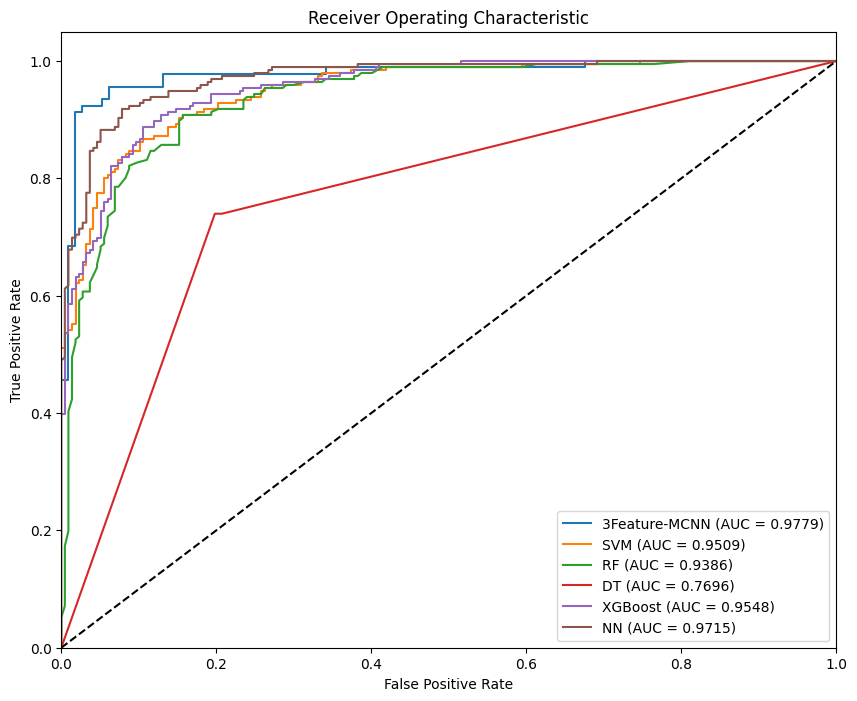

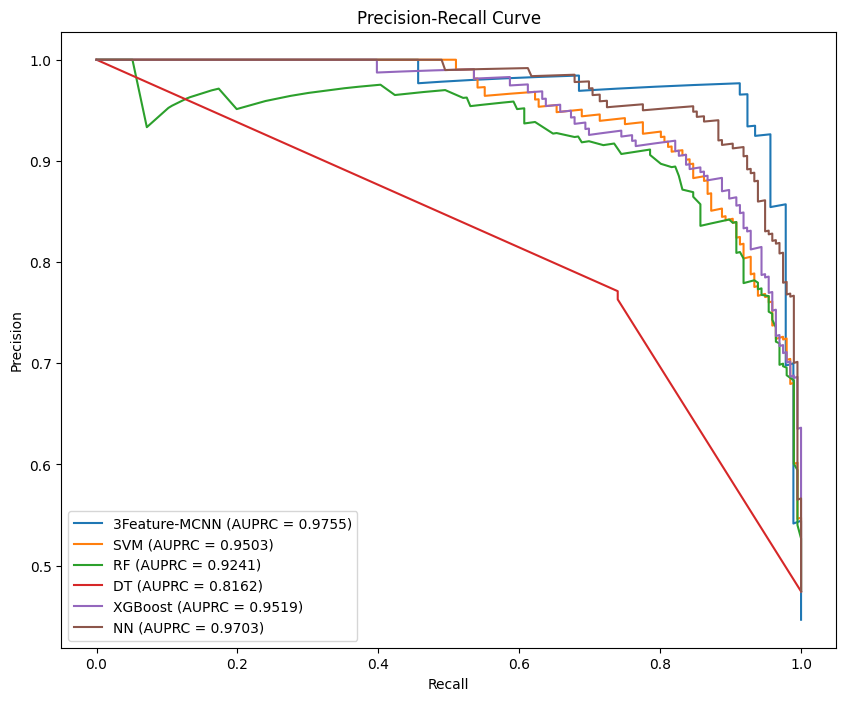

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import roc_curve, auc, precision_recall_curve, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np
import os


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CNN 分支
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1024, 256, kernel_size=9, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(1280, 256, kernel_size=9, padding='same'),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(2560, 512, kernel_size=9, padding='same'),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )

        # Attention
        self.attention = nn.MultiheadAttention(
            embed_dim=1024,
            num_heads=8,
            dropout=0.5,
            batch_first=True
        )

        # BiGRU 层
        self.bigru = nn.GRU(
            input_size=1024,
            hidden_size=128,
            bidirectional=True,
            batch_first=True
        )

        # BiLSTM 分支
        self.bilstm = nn.LSTM(1024, 128, bidirectional=True, batch_first=True)

        # 全连接层，将五个分支的输出拼接后降维
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 16),
        )

        # 分类层
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2, x3, labels=None):
        """
        inputs:
            - x1, x2, x3: 输入的三个特征
            - labels: 目标标签，通常用于计算损失函数
        """
        # CNN 分支
        x1 = x1.unsqueeze(1).permute(0, 2, 1)
        x2 = x2.unsqueeze(1).permute(0, 2, 1)
        x3 = x3.unsqueeze(1).permute(0, 2, 1)

        out1 = self.cnn1(x1).permute(0, 2, 1)
        out2 = self.cnn2(x2).permute(0, 2, 1)
        out3 = self.cnn3(x3).permute(0, 2, 1)

        # 拼接三个 CNN 输出
        merged = torch.cat([out1, out2, out3], dim=-1)

        # Attention
        attn_out, _ = self.attention(merged, merged, merged)

        # BiGRU
        bigru_out, _ = self.bigru(attn_out)

        # 全连接层
        mlp_out = self.fc1(bigru_out)
        out = self.fc2(mlp_out).squeeze(-1)

        # 取最后一个时间步的输出作为最终分类结果
        final_out = out[:, -1]

        return final_out


def calculate_metric(all_predictions, all_labels, all_outputs):
    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, matthews_corrcoef
    acc = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    auroc = roc_auc_score(all_labels, all_outputs)
    mcc = matthews_corrcoef(all_labels, all_predictions)
    specificity = recall_score(all_labels, all_predictions, pos_label=0)
    return (acc, precision, recall, specificity, f1, auroc, mcc), None, None


def cv(train_data_1, train_data_2, train_data_3, train_label, batch_size, lr, epochs, num_kfold=10, p=0.5):
    x = torch.cat([train_data_1, train_data_2, train_data_3], dim=1)
    y = train_label
    skf = KFold(n_splits=num_kfold, shuffle=True, random_state=911)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_save_dir = "./saved_models"
    os.makedirs(model_save_dir, exist_ok=True)

    best_mcc = -np.inf
    best_fold_labels = []
    best_fold_outputs = []

    for fold, (train_index, valid_index) in enumerate(skf.split(x), 1):
        x_train = x[train_index]
        x_valid = x[valid_index]

        x1_train = x_train[:, :1024]
        x2_train = x_train[:, 1024:1024 + 1280]
        x3_train = x_train[:, 1024 + 1280:]

        x1_valid = x_valid[:, :1024]
        x2_valid = x_valid[:, 1024:1024 + 1280]
        x3_valid = x_valid[:, 1024 + 1280:]

        y_train = y[train_index]
        y_valid = y[valid_index]

        num_positive = np.sum(y_train.cpu().detach().numpy())
        num_negative = len(y_train) - num_positive
        print('正样本：%d个, 负样本：%d个, 正/负: %.2f' % (num_positive, num_negative, num_positive / num_negative))

        criterion = nn.BCELoss()
        print(f'使用 BCE')

        model = Net()
        model.to(device)
        optimizer = optim.Adam(params=model.parameters(), lr=lr, weight_decay=0.0, betas=(0.9, 0.999))

        train_dataset = TensorDataset(x1_train, x2_train, x3_train, y_train)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

        val_dataset = TensorDataset(x1_valid, x2_valid, x3_valid, y_valid)
        val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

        best_epoch_mcc = -np.inf
        fold_labels = []
        fold_outputs = []

        for epoch in range(epochs):
            model.train()
            train_loss_sum = 0.0
            for inputs1, inputs2, inputs3, labels in train_dataloader:
                inputs1, inputs2, inputs3, labels = inputs1.to(device), inputs2.to(device), inputs3.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs1, inputs2, inputs3)
                loss = criterion(outputs, labels)
                train_loss_sum += loss.item()
                loss.backward()
                optimizer.step()

            model.eval()
            all_outputs, all_labels, all_predictions = [], [], []
            with torch.no_grad():
                for inputs1, inputs2, inputs3, labels in val_dataloader:
                    inputs1, inputs2, inputs3, labels = inputs1.to(device), inputs2.to(device), inputs3.to(device), labels.to(device)
                    outputs = model(inputs1, inputs2, inputs3)
                    all_outputs.extend(outputs.tolist())
                    all_labels.extend(labels.tolist())
                    all_predictions.extend((outputs.data > p).int().tolist())

            metrics, _, _ = calculate_metric(all_predictions, all_labels, all_outputs)
            acc_value, pre_value, recall_value, spe_value, f1_value, auroc_value, mcc_value = metrics
            print(f"Epoch {epoch + 1}: Acc: {acc_value:.4f}, Recall: {recall_value:.4f}, SP: {spe_value:.4f}, Pre: {pre_value:.4f}, Auroc: {auroc_value:.4f}, F1: {f1_value:.4f}, MCC: {mcc_value:.4f}")

            if mcc_value > best_epoch_mcc:
                best_epoch_mcc = mcc_value
                fold_labels = all_labels
                fold_outputs = all_outputs

        if best_epoch_mcc > best_mcc:
            best_mcc = best_epoch_mcc
            best_fold_labels = fold_labels
            best_fold_outputs = fold_outputs

        print(f"Best MCC for Fold {fold}: {best_epoch_mcc:.4f}")

    return best_fold_labels, best_fold_outputs


# 训练集输入特征
train_data_1 = torch.load(r'/content/drive/MyDrive/merged_train_ProtT5.pt', weights_only=True)
train_data_2 = torch.load(r'/content/drive/MyDrive/merged_train_esm1b.pt', weights_only=True)
train_data_3 = torch.load(r'/content/drive/MyDrive/merged_train_esm2_t36.pt', weights_only=True)

# 标签
train_labels_list = [1] * 1004 + [0] * 1059
train_label = torch.tensor(train_labels_list, dtype=torch.float)

from sklearn.utils import shuffle

train_data_1_np = train_data_1.cpu().numpy()
train_data_2_np = train_data_2.cpu().numpy()
train_data_3_np = train_data_3.cpu().numpy()
train_label_np = train_label.cpu().numpy()

train_data_1_np, train_data_2_np, train_data_3_np, train_label_np = shuffle(
    train_data_1_np, train_data_2_np, train_data_3_np, train_label_np, random_state=911
)

train_data_1 = torch.from_numpy(train_data_1_np)
train_data_2 = torch.from_numpy(train_data_2_np)
train_data_3 = torch.from_numpy(train_data_3_np)
train_label = torch.from_numpy(train_label_np)

p_value = 0.5
k_value = 10
print('阈值为%.1f' % p_value)

best_fold_labels, best_fold_outputs = cv(
    train_data_1=train_data_1,
    train_data_2=train_data_2,
    train_data_3=train_data_3,
    train_label=train_label,
    batch_size=128,
    lr=0.00003,
    epochs=30,
    num_kfold=k_value,
    p=p_value
)

X = np.hstack((train_data_1_np, train_data_2_np, train_data_3_np))
y = train_label_np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=911)

models = {
    'SVM': SVC(probability=True),
    'RF': RandomForestClassifier(),
    'DT': DecisionTreeClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'NN': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=911)
}

for name, model in models.items():
    model.fit(X_train, y_train)

# 绘制ROC曲线
plt.figure(figsize=(10, 8))

fpr_nn, tpr_nn, _ = roc_curve(best_fold_labels, best_fold_outputs)
roc_auc_nn = auc(fpr_nn, tpr_nn)
plt.plot(fpr_nn, tpr_nn, label=f'3Feature-MCNN (AUC = {roc_auc_nn:.4f})')

for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(10, 8))

# 计算3Feature-MCNN的AUPRC
precision_nn, recall_nn, _ = precision_recall_curve(best_fold_labels, best_fold_outputs)
auprc_nn = auc(recall_nn, precision_nn)
plt.plot(recall_nn, precision_nn, label=f'3Feature-MCNN (AUPRC = {auprc_nn:.4f})')

# 计算各传统模型的AUPRC
for name, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    auprc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUPRC = {auprc:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

<ipython-input-18-86bf0571db1f>:36: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  ax = sns.barplot(x="Metric", y="Value", hue="Model", data=df,


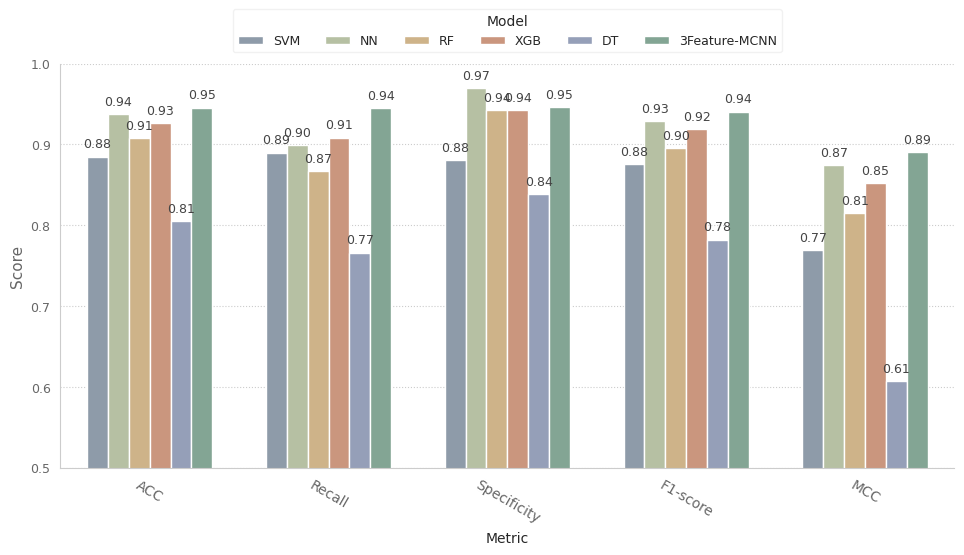

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 自定义柔和的莫兰迪配色方案
custom_palette = [
    "#8C9BAB",  # 灰蓝
    "#B7C3A0",  # 橄榄绿
    "#D4B483",  # 米驼
    "#D19477",  # 陶土
    "#929EBB",  # 灰紫
    "#80A894"   # 青灰
]

# 数据准备
data = {
    'Model': ['SVM', 'NN', 'RF', 'XGB', 'DT', '3Feature-MCNN'] * 5,
    'Metric': ['ACC'] * 6 + ['Recall'] * 6 + ['Specificity'] * 6 + ['F1-score'] * 6 + ['MCC'] * 6,
    'Value': [
        0.8849, 0.9372, 0.9079, 0.9268, 0.8054, 0.9456,
        0.8899, 0.8991, 0.8670, 0.9083, 0.7661, 0.9450,
        0.8808, 0.9692, 0.9423, 0.9423, 0.8385, 0.9462,
        0.8758, 0.9289, 0.8957, 0.9188, 0.7822, 0.9406,
        0.7690, 0.8744, 0.8149, 0.8523, 0.6070, 0.8905
    ]
}

# 将数据转换为 DataFrame
df = pd.DataFrame(data)

# 可视化设置
plt.figure(figsize=(10, 6))  # 调整为更紧凑的宽高比
sns.set_style("whitegrid", {'grid.linestyle': ':'})  # 虚线网格

# 绘制改进后的柱状图
ax = sns.barplot(x="Metric", y="Value", hue="Model", data=df,
                 palette=custom_palette,
                 saturation=0.85,  # 降低饱和度
                 width=0.7,  # 调窄柱宽
                 errwidth=0)  # 去除误差线

# 优化图形元素

plt.ylabel("Score", fontsize=11, color="#666666")
plt.ylim(0.5, 1.0)

# 改进数值标签样式
for p in ax.patches:
    value = f"{p.get_height():.2f}"
    if 'e' in value:  # 处理可能的科学计数法
        value = f"{p.get_height():.2f}"
    ax.annotate(value,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=9,
                color="#444444")

# 优化图例
legend = plt.legend(bbox_to_anchor=(0.5, 1.15),
                    loc='upper center',
                    frameon=True,
                    framealpha=0.9,
                    edgecolor='#f0f0f0',
                    title='Model',
                    title_fontsize=10,
                    fontsize=9,
                    ncol=len(df['Model'].unique()))

# 设置坐标轴样式
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#cccccc')
ax.spines['left'].set_color('#cccccc')

# 优化刻度标签
plt.xticks(fontsize=10, rotation=330, color="#666666")  # 轻微倾斜
plt.yticks(fontsize=9, color="#666666")

# 突出显示最佳表现

plt.tight_layout(pad=2)
plt.show()

<ipython-input-1-2e15ece6a501>:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = row[metrics].tolist() + [row[metrics][0]]


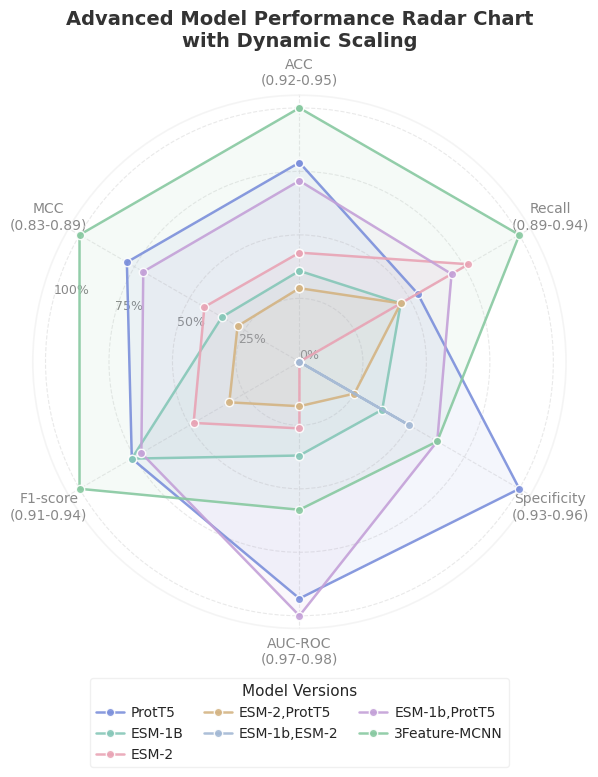

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 数据准备
data = {
    'Model': ['ProtT5', 'ESM-1b', 'ESM-2', 'ESM-2,ProtT5',
              'ESM-1b,ESM-2', 'ESM-1b,ProtT5', '3Feature-MCNN'],
    'ACC': [0.9393, 0.9268, 0.9289, 0.9248, 0.9163, 0.9372, 0.9456],
    'Recall': [0.9174, 0.9128, 0.9312, 0.9128, 0.8853, 0.9266, 0.9450],
    'Specificity': [0.9577, 0.9385, 0.9269, 0.9346, 0.9423, 0.9462, 0.9462],
    'AUC-ROC': [0.9796, 0.9738, 0.9727, 0.9718, 0.9700, 0.9803, 0.9760],
    'F1-score': [0.9324, 0.9324, 0.9227, 0.9171, 0.9061, 0.9309, 0.9406],
    'MCC': [0.8778, 0.8523, 0.8570, 0.8481, 0.8315, 0.8734, 0.8905]
}
df = pd.DataFrame(data)
metrics = df.columns[1:]

import seaborn as sns

# 然后直接使用（无需style.use）
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(10, 8), dpi=100)
ax = fig.add_subplot(111, polar=True)

# 专业配色方案
colors = [
    '#7C90DB',  # 静谧蓝
    '#86C7B8',  # 薄荷绿
    '#E9A4B5',  # 灰粉
    '#D4B483',  # 米驼
    '#A3B8D4',  # 灰蓝
    '#C4A1D8',  # 淡紫
    '#88C9A1'   # 青绿
]

# 角度计算
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

# 数据归一化
normalized = df.copy()
for metric in metrics:
    min_val = df[metric].min()
    max_val = df[metric].max()
    normalized[metric] = (df[metric] - min_val) / (max_val - min_val)

# 高级绘图参数
LINE_STYLE = {
    'linewidth': 1.8,
    'alpha': 0.9,
    'linestyle': '-',
    'marker': 'o',
    'markersize': 6,
    'markeredgecolor': 'white',
    'markerfacecolor': 'auto'
}

# 绘制每个模型
for idx, (_, row) in enumerate(normalized.iterrows()):
    values = row[metrics].tolist() + [row[metrics][0]]
    ax.plot(angles, values, color=colors[idx], label=row['Model'], **LINE_STYLE)
    ax.fill(angles, values, color=colors[idx], alpha=0.08)

# 可视化增强设置
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(285)

# 网格和刻度优化
ax.grid(color='#E0E0E0', linestyle='--', linewidth=0.8, alpha=0.7)
ax.set_xticks(angles[:-1])
ax.set_xticklabels([f"{m}\n({df[m].min():.2f}-{df[m].max():.2f})"
                  for m in metrics],
                 fontsize=10, color='#555555')
ax.set_yticks(np.linspace(0,1,5))
ax.set_yticklabels([f"{v:.0%}" for v in np.linspace(0,1,5)],
                  fontsize=9, color='#777777')

# 专业图例设计
# 修改图例部分的代码 (原代码其他部分保持不变)
legend = ax.legend(
    loc='upper center',           # 基准定位点
    bbox_to_anchor=(0.5, -0.08),  # 坐标偏移量 (水平居中，向下偏移25%)
    frameon=True,
    framealpha=0.95,
    edgecolor='#F0F0F0',
    fontsize=10,
    title='Model Versions',
    title_fontsize=11,
    ncol=3,                       # 分3列显示
    columnspacing=1.5,            # 列间距
    handletextpad=0.5             # 图例项间距
)

# 同时需要调整底部边距
#plt.subplots_adjust(bottom=0.1)   # 为底部图例留出30%高度
# 标题和注释
plt.title("Advanced Model Performance Radar Chart\nwith Dynamic Scaling",
         pad=35, fontsize=14, fontweight='semibold', color='#333333')

# 透明度优化
ax.spines['polar'].set_alpha(0.2)
ax.tick_params(axis='both', colors='#888888')

plt.tight_layout()
plt.show()

<ipython-input-3-1ce2692e7462>:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = row[metrics].tolist() + [row[metrics][0]]


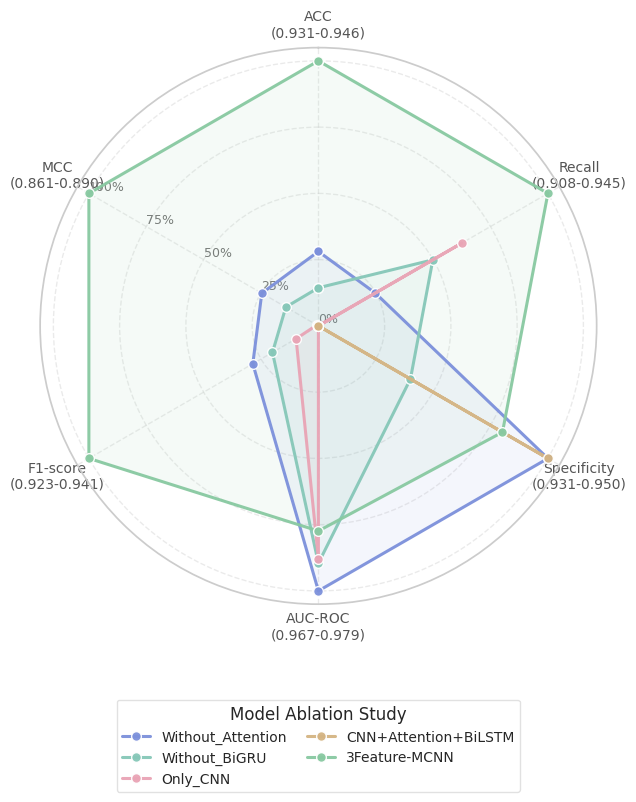

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# 设置现代可视化样式
sns.set_theme(style="whitegrid", rc={
    "grid.linestyle": "--",
    "grid.alpha": 0.4,
    "axes.edgecolor": "#cccccc"
})

# 数据准备
data = {
    'Model': ['Without_Attention', 'Without_BiGRU', 'Only_CNN', 'CNN+Attention+BiLSTM', '3Feature-MCNN'],
    'ACC': [0.9351, 0.9331, 0.9310, 0.9310, 0.9456],
    'Recall': [0.9174, 0.9266, 0.9312, 0.9083, 0.9450],
    'Specificity': [0.9500, 0.9385, 0.9308, 0.9500, 0.9462],
    'AUC-ROC': [0.9786, 0.9774, 0.9772, 0.9671, 0.9760],
    'F1-score': [0.9281, 0.9266, 0.9248, 0.9231, 0.9406],
    'MCC': [0.8682, 0.8651, 0.8611, 0.8609, 0.8905]
}
df = pd.DataFrame(data)
metrics = df.columns[1:]

# 专业配色方案
colors = [
    '#7C90DB',  # 静谧蓝
    '#86C7B8',  # 薄荷绿
    '#E9A4B5',  # 灰粉
    '#D4B483',  # 米驼
    '#88C9A1'   # 青绿
]

# 创建画布
fig = plt.figure(figsize=(10, 8), dpi=100)
ax = fig.add_subplot(111, polar=True)

# 计算角度和范围
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]
ranges = {metric: (df[metric].min(), df[metric].max()) for metric in metrics}

# 数据归一化处理
normalized = df.copy()
for metric in metrics:
    min_val, max_val = ranges[metric]
    normalized[metric] = (df[metric] - min_val) / (max_val - min_val)

# 高级绘图参数
plot_config = {
    'linewidth': 2.2,
    'alpha': 0.95,
    'marker': 'o',
    'markersize': 7,
    'markeredgecolor': 'white',
    'markerfacecolor': 'auto'
}

# 绘制每个模型
for idx, row in normalized.iterrows():
    values = row[metrics].tolist() + [row[metrics][0]]
    ax.plot(angles, values, color=colors[idx], label=row['Model'], **plot_config)
    ax.fill(angles, values, color=colors[idx], alpha=0.08)

# 可视化增强设置
ax.set_theta_offset(np.pi/2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(300)

# 动态轴标签
ax.set_xticks(angles[:-1])
ax.set_xticklabels([f"{m}\n({ranges[m][0]:.3f}-{ranges[m][1]:.3f})"
                   for m in metrics], fontsize=10, color='#555555')

# 百分比刻度
yticks = np.linspace(0, 1, 5)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{v:.0%}" for v in yticks], fontsize=9, color='#777777')

# 底部图例设计
legend = ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.35),
    frameon=True,
    framealpha=0.95,
    edgecolor='#e0e0e0',
    ncol=2,
    fontsize=10,
    title='Model Ablation Study',
    title_fontsize=12,
    columnspacing=1.5
)

# 标题和注释

# 布局优化
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()